In [1]:
import itk
import matplotlib.pyplot as plt

# Chemins des fichiers d'image
fixed_filepath = 'Data/case6_gre1.nrrd'
moving_filepath = 'Data/case6_gre2.nrrd'
output_filepath = 'output_transformed_image.nrrd'

# Définir le type d'image
PixelType = itk.F
Dimension = 3
ImageType = itk.Image[PixelType, Dimension]

# Charger les images
fixed_image = itk.imread(fixed_filepath, PixelType)
moving_image = itk.imread(moving_filepath, PixelType)

# Définir la transformation B-spline déformable
TransformType = itk.BSplineTransform[itk.D, Dimension, 3]
initial_transform = TransformType.New()

# Configurer les paramètres de la transformation B-spline
mesh_size = [10] * Dimension  # Taille de la grille des splines B
initial_transform.SetTransformDomainMeshSize(mesh_size)
initial_transform.SetTransformDomainOrigin(fixed_image.GetOrigin())
initial_transform.SetTransformDomainPhysicalDimensions(
    fixed_image.GetSpacing() * fixed_image.GetLargestPossibleRegion().GetSize()
)

# Initialiser les coefficients de la transformation à zéro
parameters = initial_transform.GetParameters()
parameters.Fill(0.0)
initial_transform.SetParameters(parameters)

# Définir le type d'optimiseur et métrique
OptimizerType = itk.LBFGSOptimizerv4
optimizer = OptimizerType.New()

MetricType = itk.MeanSquaresImageToImageMetricv4[ImageType, ImageType]
metric = MetricType.New()

# Configurer le processus de recalage
RegistrationType = itk.ImageRegistrationMethodv4[ImageType, ImageType]
registration = RegistrationType.New()
registration.SetMetric(metric)
registration.SetOptimizer(optimizer)
registration.SetFixedImage(fixed_image)
registration.SetMovingImage(moving_image)
registration.SetInitialTransform(initial_transform)
registration.SetNumberOfLevels(2)

# Configurer l'optimiseur
optimizer.SetGradientConvergenceTolerance(1e-5)
optimizer.SetLineSearchAccuracy(0.9)
optimizer.SetDefaultStepLength(1.5)
optimizer.SetMaximumNumberOfFunctionEvaluations(200)

# Démarrer le recalage
registration.Update()


Iterations = 1
Metric value = 46299.16880123795


(-0.5, 255.5, 255.5, -0.5)

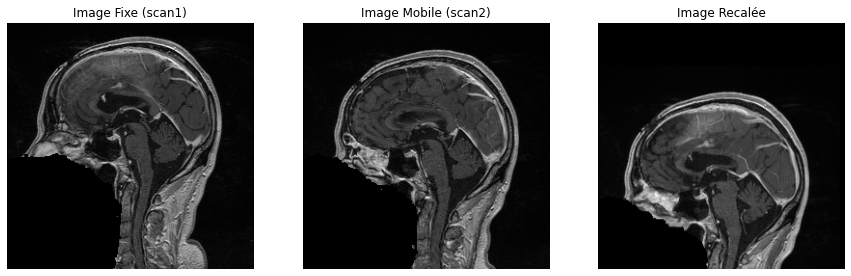

In [2]:
# Afficher les informations sur le recalage
number_of_iterations = optimizer.GetCurrentIteration()
best_value = optimizer.GetValue()
print(f"Iterations = {number_of_iterations}")
print(f"Metric value = {best_value}")

# Récupérer la transformation finale
final_transform = registration.GetModifiableTransform()

# Définir l'interpolateur pour le resampling
InterpolatorType = itk.LinearInterpolateImageFunction[ImageType, itk.D]
interpolator = InterpolatorType.New()

# Appliquer la transformation à l'image mobile
resampler = itk.ResampleImageFilter.New(Input=moving_image, Transform=final_transform, UseReferenceImage=True, ReferenceImage=fixed_image)
resampler.SetInterpolator(interpolator)
resampler.SetDefaultPixelValue(0)
transformed_image = resampler.GetOutput()

# Sauvegarder l'image recalée
itk.imwrite(transformed_image, output_filepath)

# Optionnel : afficher les résultats
fixed_array = itk.array_from_image(fixed_image)
moving_array = itk.array_from_image(moving_image)
transformed_array = itk.array_from_image(transformed_image)

slice_index = fixed_array.shape[0] // 2

# Visualiser les images avant et après le recalage
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(fixed_array[slice_index, :, :], cmap='gray')
axes[0].set_title('Image Fixe (scan1)')
axes[0].axis('off')

axes[1].imshow(moving_array[slice_index, :, :], cmap='gray')
axes[1].set_title('Image Mobile (scan2)')
axes[1].axis('off')

axes[2].imshow(transformed_array[slice_index, :, :], cmap='gray')
axes[2].set_title('Image Recalée')
axes[2].axis('off')